In [303]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json
import os

DB_EPS = 1e-6
EPS = 1e-9

In [313]:
def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append({'path': os.path.join(root,file), 'data' : None})
  return ret

In [316]:
hypertone_dir = '/content/drive/MyDrive/hypertone/'
preprocessing_data_file = hypertone_dir + 'preprocessing/data.json'
model_file = hypertone_dir + 'model/model.h5'
directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [317]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [327]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[1]['files']

[{'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a'},
 {'data': 

In [281]:
kTones = 8
kBinsPerOctave = 12
kJump = int(4/3 * kBinsPerOctave)

fmin = librosa.midi_to_hz(36) # C2
fmax = librosa.midi_to_hz(84) # C6

In [227]:
def debug_frequencies(freqs):
  print("size=" + str(len(freqs)))
  for index, elem in enumerate(freqs):
    c = '\n' if index % 8 == 0 else ' || '
    print(str(index) + " -> " + str(int(elem)),end=c)
  print('')
  pass


def debug(curr, b, e):
  for x in curr[b:e]:
    for elem in x:
      print(elem, end=',')
    print('')
  pass

def plot_lms(lms_, sr_):
  plt.figure(figsize=(30, 10))
  librosa.display.specshow(lms_, 
                          x_axis="time",
                          y_axis="mel", 
                          sr=sr_)
  plt.colorbar(format="%+2.f")
  plt.show()
  pass

def lower_bound(arr, needle):
# Lower-bound to find frequencies
  n = len(arr)
  lower, half = 0, n // 2
  while half:
    middle = lower + half;
    lower = middle if arr[middle] <= needle else lower
    n -= half
    half = n // 2
  return lower

In [340]:
# TODO: adaptively change this!
kOffset = 0 # 5 sec

# TODO: use also CQT_CHROMA!!!
def analyze_audio(filename, verbose=False):
  scale, sr = librosa.load(filename)
  fmin = librosa.midi_to_hz(36) # C2
  fmax = librosa.midi_to_hz(84) # C6 (not used)

  # TODO: put 24 bins per octave
  X = librosa.cqt(scale[kOffset:], sr=sr, fmin=fmin, bins_per_octave=kBinsPerOctave)  
  kBins = X.shape[0]
  print("initial=" + str(X.shape))

  pos_fmax = lower_bound(librosa.cqt_frequencies(n_bins=kBins, fmin=fmin), fmax)

  orig_logX = librosa.amplitude_to_db(abs(X))
  
  # Transpose
  logX = np.transpose(orig_logX).copy()

  # Zero-out minus db
  logX[logX < 0] = 0

  # Zero-out > fmax
  logX[:,(1 + pos_fmax):] = 0

  # Clear empty columns
  logX = logX[~np.all(logX < DB_EPS, axis=1)]

  # Scale
  scaler = MinMaxScaler()
  logX = scaler.fit_transform(logX)
  
  print("transofrmed=" + str(logX.shape))
  
  if verbose:
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logX.T, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

  melody = []
  for index in range(len(logX)):
    tmp = np.zeros(kBinsPerOctave)
    for bin in range(kBins):
      tmp[bin % kBinsPerOctave] += logX[index][bin]
    max_pos = np.argmax(tmp)
    assert 0 <= max_pos and max_pos < kBinsPerOctave
    melody.append(max_pos)
  return np.asarray(melody)

In [336]:
def encode_audio(filename):
  melody = analyze_audio(filename)
  return np.diff(melody)

In [337]:
filename=tones[1]['files'][0]['path']
ipd.Audio(filename)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1761)
transofrmed=(1263, 84)


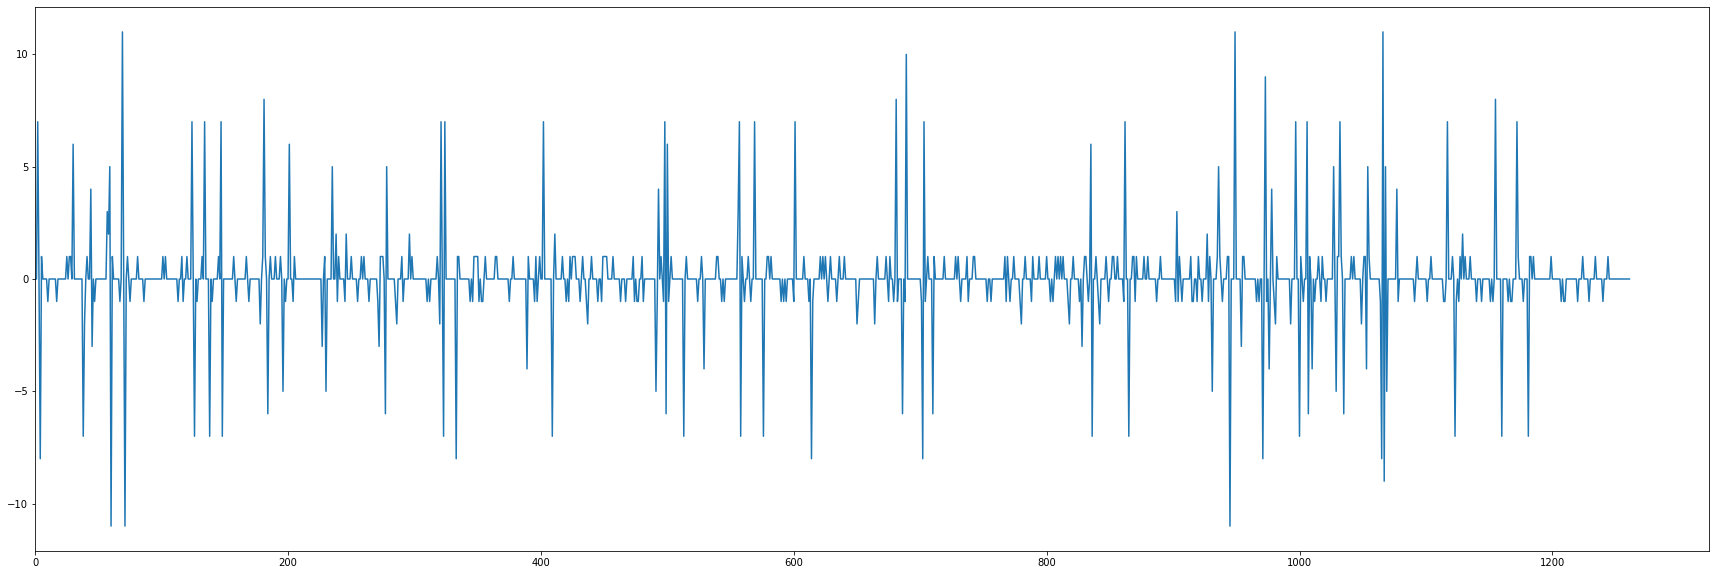

In [341]:
encoded_audio = encode_audio(filename)
plt.figure(figsize=(30, 10))
plt.plot(encoded_audio)
plt.xlim(xmin=0)
plt.show()

In [324]:
def preprocess():
  for tone in tones:
    if tone != 8 and tone != 1:
      continue
    print('Tone: ' + str(tone))
    count = 2
    for index, file in enumerate(tones[tone]['files']):
      if index == count:
        break
      print('Audio: ' + file['path'])
      tones[tone]['files'][index]['data'] = encode_audio(file['path'])
  pass

In [342]:
preprocess()

Tone: 1
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1761)
transofrmed=(1263, 84)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5845)
transofrmed=(4534, 84)
Tone: 8
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.3 Primul rând de sedelne.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9506)
transofrmed=(7402, 84)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1486)
transofrmed=(1112, 84)


In [343]:
def prepare_data():
  print('Save tones..')
  acc = []
  for tone in tones:
    print('Tone: ' + str(tone))
    for index, file in enumerate(tones[tone]['files']):
      if tones[tone]['files'][index]['data'] is not None:
        acc.append({'x': tones[tone]['files'][index]['data'].tolist(), 'y': tone - 1})
  return acc

with open(preprocessing_data_file, 'w') as f:
  data = prepare_data()
  json.dump(data, f, indent=2)

Save tones..
Tone: 1
Tone: 2
Tone: 3
Tone: 4
Tone: 5
Tone: 6
Tone: 7
Tone: 8


In [420]:
import tensorflow.keras as keras

# TODO: check the best one!
kSequenceLength = 256
kOutputUnits = 2 * kBinsPerOctave - 1
kNumUnits = [256, 64]
kLoss = "sparse_categorical_crossentropy"
kLearningRate = 0.001
kEpochs = 5
kBatchSize = 64

In [383]:
def load(path):
  with open(path, 'r') as f:
    return json.load(f)

In [406]:
def compress(a):
  return a[np.logical_or(np.insert(np.diff(a).astype(bool), 0, True), np.asarray(a, dtype=bool))]

def generate_training_sequences(seq_len):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = load(preprocessing_data_file)

  inputs, targets = [], []
  for elem in songs:
    print("Uncompressed: " + str(len(elem['x'])))
    x = compress(np.asarray(elem['x']))
    print("Compresed: " + str(len(x)))
    y = elem['y']
    #x[np.insert(np.diff(x).astype(np.bool), 0, True)]
    if len(x) < seq_len:
      x.resize(seq_len)
    num_sequences = len(x) - seq_len + 1
    for index in range(num_sequences):
      inputs.append(x[index : index + seq_len])
      targets.append(y)

  # one-hot encode the sequences  
  # inputs size: (# of sequences, sequence length, vocabulary size)
  inputs = keras.utils.to_categorical(inputs, num_classes=kOutputUnits)
  print(f"There are {len(inputs)} sequences.")
  return inputs, np.asarray(targets)

In [407]:
print(generate_training_sequences(kSequenceLength))

Uncompressed: 1262
Compresed: 645
Uncompressed: 4533
Compresed: 1884
Uncompressed: 7401
Compresed: 3160
Uncompressed: 1111
Compresed: 465
There are 5134 sequences.
(array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.

In [421]:
import tensorflow.keras as keras

def build_model(output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    input = keras.layers.Input(shape=(kSequenceLength, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    #x = keras.layers.LSTM(num_units[1])(x)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(kTones, activation="softmax")(x)
    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model


def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    # build the network
    model = build_model(output_units, num_units, loss, learning_rate)

    # train the model
    model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize)

    # save the model
    model.save(model_file)

In [422]:
train()

Uncompressed: 1262
Compresed: 645
Uncompressed: 4533
Compresed: 1884
Uncompressed: 7401
Compresed: 3160
Uncompressed: 1111
Compresed: 465
There are 5134 sequences.
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256, 23)]         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               286720    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 2056      
Total params: 288,776
Trainable params: 288,776
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
81/81 [==============================] - 81s 980ms/step - loss: 0.7797 - acc

In [424]:
class HyperTone:
  """A class that wraps the LSTM model and offers utilities to generate melodies."""

  def __init__(self):
    """Constructor that initialises TensorFlow model"""
    self.model = keras.models.load_model(model_file)
  
  def extract_tones(self, x):
    # Compress
    x = compress(x)

    # Pad, if necessary
    if len(x) < kSequenceLength:
      x.resize(kSequenceLength)

    y = []
    num_sequences = len(x) - kSequenceLength + 1
    for index in range(250, min(500, num_sequences)):
      seed = x[index : index + kSequenceLength]

      # one-hot encode the seed
      onehot_seed = keras.utils.to_categorical(seed, num_classes=kOutputUnits)

      # (1, max_sequence_length, num of symbols in the vocabulary)
      onehot_seed = onehot_seed[np.newaxis, ...]

      # make a prediction
      probabilities = self.model.predict(onehot_seed)[0]
      index = self.sample(probabilities)
      y.append(1 + index)              
    return y

  def sample(self, probabilites, temperature=0.1):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [425]:
ht = HyperTone()
f1 = tones[1]['files'][0]['path']
f8 = tones[8]['files'][0]['path']

In [369]:
ipd.Audio(f1)

In [370]:
ipd.Audio(f8)

In [426]:
print(ht.extract_tones(encode_audio(f1)))
print(ht.extract_tones(encode_audio(f8)))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1761)
transofrmed=(1263, 84)
[1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 8, 1, 8, 1, 1, 1, 1, 1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 8, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9506)
transofrmed=(7402, 84)
[8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 8, 1, 1, 1, 8, 8, 8, 8, 1, 1, 1, 1, 8, 1, 1, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 8, 8, 1, 1, 1, 8, 8, 1, 8, 1, 1, 1, 8, 1, 1, 1, 8, 1, 1, 1, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 8, 1, 1, 1, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 1, 8, 1, 1, 1, 1, 1]
